<a href="https://colab.research.google.com/github/hashimmg/jax_ib/blob/main/Copy_of_journal_bearing_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc
import jax_ib.base as ib
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax_ib.base import boundaries
from jax import random
from jax_md import space, quantity
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import jax_ib

<font size="4">Simulation setup steps <font size="4">:
 1. Setup the Flow problem
 2. Setup the Immersed object kinematics
 3. Setup the Brownian dynamics

<font size="5"> Flow Problem Setup <font size="5">

In [21]:
#-- Flow conditions
density = 1.0
viscosity = 0.05
dt=8e-5
inner_steps = 10#1800#20#450#1500#1300
outer_steps = 100#6000#12000#3000#2000#4500#4500#1800#10#900#20 (18000 works well to reach steady state)


#-- CFD Boundary condition parameters
freq=[0.]*4
A=[0.]*4
B=[0.]*4
C=[0.]*4
D=[0.]*4

domain = ((0,5.),(0,5.0))
size=(300,300)
grid = ib.grids.Grid(size, domain=domain)

def Boundary_fn(t):
    return 0.0

bc_fns = [Boundary_fn for a,b,c,d,f in zip(A,B,C,D,freq)]
vx_bc=((bc_fns[0](0.0), bc_fns[1](0.0)), (bc_fns[2](0.0),bc_fns[3](0.0)))
vy_bc=((0.0, 0.0), (0, 0.0))

velocity_bc = (
    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))


def convect(v):
    return tuple(ib.advection.advect_upwind(u, v, dt) for u in v)


#-- Initial velocity profile
vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)



velocity_fns = (vx_fn, vy_fn)
v0 = tuple(grid.eval_on_mesh(v_fn, offset) for v_fn, offset in zip(velocity_fns, grid.cell_faces))

v0 = tuple(
      ib.grids.GridVariable(u, bc) for u, offset,
      bc in zip(v0, grid.cell_faces, velocity_bc))

#-- Initial Pressure Profile

pressure0 = ib.grids.GridVariable(ib.grids.GridArray(jnp.zeros_like(v0[0].data), grid.cell_center, grid), ib.boundaries.get_pressure_bc_from_velocity(v0))



<font size="5"> Immersed Boudary Kinematics <font size="5">

In [22]:
#-- Immersed objects
rad_ratio = 0.5
alpha0 = [jnp.pi/2]*2
n_terms = 1
alpha_1 = [0.0]*n_terms
beta_1 = [0.0]*n_terms
alpha_2 = [0.0]*n_terms
beta_2 = [0.0]*n_terms
frequency = 1.0
theta_out = jnp.pi/2*1.9#
omega = 3.0
p_H = 1.
p_P = 1.

# Specify Immersed Objects Geometery and Initial locations

def foil_XY_circle(geometry_param,theta):
    A = geometry_param[0]
    ntheta = 80#150 (150 worked well)
    #xt = jnp.array(theta[:len(theta)//2]/(jnp.pi))
    theta = jnp.linspace(0,1.98*jnp.pi,ntheta)
    xt = A*jnp.cos(theta)
    yt = A*jnp.sin(theta)
    return xt,yt

particle_geometry_param = [[1.*rad_ratio,1.*rad_ratio],[1.0,1.0]]
particle_center_position=[[2.5,2.5],[2.5,2.5]]


# Specify Immersed Objects kinematics

displacement_param=[[0.,0.,0.,jnp.array([1.]),jnp.array([1.]),0.],
            [0.,0.,0.,jnp.array([1.]),jnp.array([1.]),0]]#,[jnp.array([1,2,5]),3]]

rotation_param=[[alpha0[0],frequency,0.,jnp.array(alpha_1),jnp.array(beta_1),theta_out*omega,p_H],
            [alpha0[1],frequency,0.,-jnp.array(alpha_2),jnp.array(beta_2),theta_out,p_P]]

Displacement_EQ = ks.Displacement_Foil_Fourier_Dotted_Mutliple
Rotation_EQ = ks.rotation_Foil_Fourier_Dotted_Mutliple_NORMALIZED


Shape_fn = foil_XY_circle
mygrids= pc.Grid1d(2, domain= (0, 2*jnp.pi)) # Only needed when using Penalty method simulation setup

particles =  pc.Particle(jnp.array(particle_center_position),jnp.array(particle_geometry_param),displacement_param,rotation_param,mygrids,Shape_fn,Displacement_EQ,Rotation_EQ)

<font size="5"> Brownian Dynamics <font size="5">

In [23]:
#----- Setup Brownian Simulation----------#

# Brownian Particles
dt_MD = dt
kT = 0.0
num_distrib = 600
num_outer_bc = 200
key = random.PRNGKey(0)
key1 = random.PRNGKey(1)
key2 = random.PRNGKey(2)
gamma_val = 1.0


import jax.numpy as jnp
from jax.random import uniform as random_uniform


# Setup different types of particles including force points for the immersed objects

# Immersed Object point forces to setup repulsive hard wall boundaries
Outer_Rad, Inner_Rad = particle_geometry_param[1][0], particle_geometry_param[0][0]
Inner_particle_center, Outer_particle_center = particle_center_position[0], particle_center_position[1]

    # Inner cylinder point
pos_fixed_inner = jnp.array([Inner_particle_center])

    # Outer boundary particle
theta = jnp.linspace(0, 2 * jnp.pi, num_outer_bc)
x_outer = Outer_Rad * jnp.cos(theta) + Outer_particle_center[0]
y_outer = Outer_Rad * jnp.sin(theta) + Outer_particle_center[1]
pos_fixed_outer = jnp.moveaxis(jnp.array([x_outer, y_outer]), 0, -1)


# Interior passive particles

    # Upper Half of the domain
eps_val = 1e-2
theta_p_upper = random_uniform(key, shape=(num_distrib,), minval=0., maxval=jnp.pi)
distance = Outer_particle_center[0] - Inner_particle_center[0]
p1, p2 = Inner_Rad, jnp.sqrt(Outer_Rad**2 + distance**2 - 2*Outer_Rad*distance*jnp.cos(jnp.pi-theta_p_upper))
R_p_upper = p1 + random_uniform(key1, shape=(num_distrib,), minval=0. + eps_val, maxval=1. - eps_val) * (p2 - p1)

updated_angle = jnp.arctan2(Outer_Rad * jnp.sin(theta_p_upper), distance + Outer_Rad * jnp.cos(theta_p_upper))
x_upper, y_upper = R_p_upper * jnp.cos(updated_angle) + Inner_particle_center[0], R_p_upper * jnp.sin(updated_angle) + Inner_particle_center[1]


    # Lower Half of the domain
x_lower, y_lower = x_upper, -y_upper + 2*Inner_particle_center[1]

# BrownianState Variables

    # Particles initial position
Pos_all = jnp.concatenate([jnp.moveaxis(jnp.array([x_upper, y_upper]), 0, -1),
                               jnp.moveaxis(jnp.array([x_lower, y_lower]), 0, -1),
                               pos_fixed_outer,
                               pos_fixed_inner])

    # Particles repulsive radius
Rad_outer_wall = Outer_Rad * 2 * jnp.pi / num_outer_bc
r0_array = jnp.array([[0., Rad_outer_wall, Inner_Rad],
                      [Rad_outer_wall, 0., 0.],
                      [Inner_Rad, 0.0, 0.0]])

    # Morse repulsion interaction matrix

h_array = jnp.array([[0., 5.0, 5.0],
                         [5.0, 0., 0.],
                         [5.0, 0.0, 0.0]])

    # Fixing immersed object piont forces

is_mobile = jnp.concatenate([jnp.ones(2 * num_distrib), jnp.zeros([num_outer_bc + 1])])

    # Define species type needed for interaction matrix

species_moving=jnp.full(2*num_distrib, 0)
species_wall = jnp.full(num_outer_bc,1)
species_inner = jnp.array([2])
species=jnp.concatenate([species_moving,species_wall,species_inner])


#-- Brownian Dynamics Setup

displacement, shift=space.periodic(domain[0][1], wrapped=False)

fixed_harmonic = lambda displacement_or_metric, h,r0: MD.interaction_potential.harmonic_morse_pair(displacement_or_metric, species=species, h=h, D0=0.0, alpha=10.0, r0=r0, k=1.0)

def masked_shift(R, dR, is_mobile=None):
    if is_mobile is None:
        return shift(R, dR)
    return jnp.where(is_mobile[:, None], shift(R, dR), R)

energy_fn = fixed_harmonic(displacement, h_array, r0_array)
energy_fn=quantity.force(energy_fn)


def new_energy_fn(R, **kwargs):
    return energy_fn(R)

init_fn, apply_fn = MD.simulate.brownian_cfd(new_energy_fn, masked_shift, dt_MD,kT,MD.CFD_MD_coupling.custom_force_fn_pbc, gamma=gamma_val)
apply_fn = jax.jit(apply_fn)
MD_state = init_fn(key2, Pos_all, mass=1.)
def step_fn_MD(state):
        return apply_fn(state, is_mobile=is_mobile)


# Integrating Brownian Step during numerical integration of the Navier-Stokes equation

Update_position = lambda v,dt:ib.particle_motion.Update_particle_position_Multiple_and_MD_Step(step_fn_MD,v,dt)



<font size="5"> Simulation Setup <font size="5">

In [24]:

#-- Setup Pytree Variable to be looped over during integration steps

Intermediate_calcs = [0] ## If one is interested to perform post-calculation without the need to save large trajectories
Step_counter = 0

all_variables = pc.All_Variables(particles,v0,pressure0,Intermediate_calcs,Step_counter,MD_state)

#-- IB force coupling functions
def internal_post_processing(all_variables,dt):
    return all_variables

# Force convolution kernel
discrete_delta = lambda x,x0,w1: ib.convolution_functions.gaussian(x,x0,w1)

# Convultion Discretized Integral
surf_fn =  lambda field,xp,yp:ib.convolution_functions.convolve(field,xp,yp,discrete_delta)

# IB forcing function
IBM_forcing = lambda variables,dt: ib.IBM_Force.immersed_boundary_force(variables.velocity,
                                                                     variables.particles, 
                                                                     discrete_delta,
                                                                     surf_fn,
                                                                     dt)
step_fn = cfd.funcutils.repeated(
    ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag,
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated,
        IBM_forcing = IBM_forcing,
        Updating_Position = Update_position,
        Drag_fn = internal_post_processing, ### TO be removed from the example
        ),
    steps=inner_steps)


#rollout_fn = jax.jit(cfd.funcutils.trajectory(
#        step_fn, outer_steps, start_with_input=True))

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))

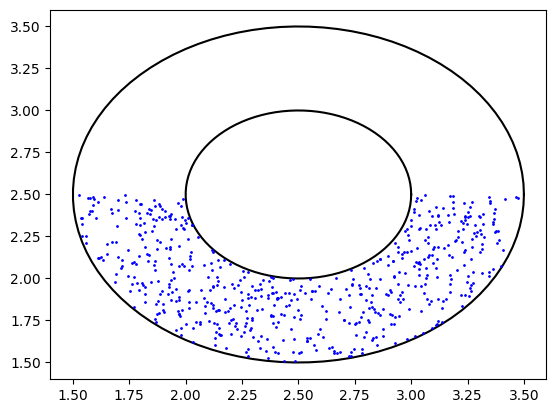

In [120]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython import display
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
fps=2
plt.ion()
#fig, ax = plt.subplots()
#fig.canvas.draw(block=False)
#fig10 = plt.figure(dpi=400,figsize=(8/2,8/2))
rot = ks.rotation_Foil_Fourier_Dotted_Mutliple_NORMALIZED
MD_trajectories = trajectory.MD_var.position
loc = 0
fig, ax = plt.subplots()
l1,  = ax.plot(MD_trajectories[loc][-1,0]+rad_ratio*jnp.cos(jnp.linspace(0,2*jnp.pi,100)),MD_trajectories[loc][-1,1]+rad_ratio*jnp.sin(jnp.linspace(0,2*jnp.pi,100)),'-k')
l2, = ax.plot(Inner_particle_center[0]+1.*jnp.cos(jnp.linspace(0,2*jnp.pi,100)),Inner_particle_center[0]+1.0*jnp.sin(jnp.linspace(0,2*jnp.pi,100)),'-k')
#l3, = ax.plot(MD_trajectories[loc][:num_distrib,0],MD_trajectories[loc][:num_distrib,1],'o',color=colors[0],markersize=1)
l4, =  ax.plot(MD_trajectories[loc][num_distrib:2*num_distrib,0],MD_trajectories[loc][num_distrib:2*num_distrib,1],'o',color=colors[1],markersize=1)

for loc in range(0, 10, 100):
    #l3.set_xdata(MD_trajectories[loc][:num_distrib,0])
    #l3.set_ydata(MD_trajectories[loc][:num_distrib,1])
    #l3.set_xdata(MD_trajectories[loc][:num_distrib,0],MD_trajectories[loc][:num_distrib,1],'o',color=colors[0],markersize=1)
    #ax.plot(MD_trajectories[loc][num_distrib:2*num_distrib,0],MD_trajectories[loc][num_distrib:2*num_distrib,1],'o',color=colors[1],markersize=1)
    l4.set_xdata(MD_trajectories[loc][num_distrib:2*num_distrib,0])
    l4.set_ydata(MD_trajectories[loc][num_distrib:2*num_distrib,1])
    #ax.draw()
    fig.canvas.draw()
    plt.pause(1)
    #plt.clf()
#line3.set_xdata(MD_trajectories[loc][:num_distrib,0])
#line3.set_ydata(MD_trajectories[loc][:num_distrib,1])
#line4.set_xdata(MD_trajectories[loc][num_distrib:2*num_distrib,0])
#line4.set_ydata(MD_trajectories[loc][num_distrib:2*num_distrib,1])

#plt.show()
#loc = 10
#ine4.set_xdata(MD_trajectories[loc][num_distrib:2*num_distrib,0])
#ine4.set_ydata(MD_trajectories[loc][num_distrib:2*num_distrib,1])

#plt.show()

In [ ]:
line3.

In [73]:
ax.scatter(MD_trajectories[loc][-1,0]+rad_ratio*jnp.cos(myth[0]),MD_trajectories[loc][-1,1]+rad_ratio*jnp.sin(myth[0]),marker='<',color='m',s=10)
ax.scatter(Inner_particle_center[0]+1.*jnp.cos(myth[1]),Inner_particle_center[0]+1.*jnp.sin(myth[1]),marker='>',color='c',s=10)

In [10]:
metadata = dict(title='Wav Spectrogram', artist='Matplotlib', comment='')
writer = animation.FFMpegWriter(fps=fps, metadata=metadata, bitrate=3500)

In [ ]:
for i in range(100):
        loc = i
        timess = loc*inner_steps*dt
        myth = rot(rotation_param,timess)
        #print('Trajectory',loc,timess,myth)

        #plt.clf()
        colors = ['r','b']
        j=0

        am =ax.plot(MD_trajectories[loc][:num_distrib,0],MD_trajectories[loc][:num_distrib,1],'o',color=colors[0],markersize=0.3)
        am =ax.plot(MD_trajectories[loc][num_distrib:2*num_distrib,0],MD_trajectories[loc][num_distrib:2*num_distrib,1],'o',color=colors[1],markersize=0.3)
        #am = plt.plot(MD_trajectories[loc][2*num_distrib:2*num_distrib+num_outer_bc,0],MD_trajectories[loc][2*num_distrib:2*num_distrib+num_outer_bc,1],'ok')
        #am = plt.plot(Inner_Rad*+trajectories[i][-1,0],trajectories[i][-1,1],'m')
        #circle1 = plt.Circle((trajectories[i][-1,0],trajectories[i][-1,1] ), Inner_Rad, color='c')
       # am = plt.scatter(MD_trajectories[j][loc][-1,0],MD_trajectories[j][loc][-1,1],s=4000)

        #am = ax.scatter(MD_trajectories[loc][-1,0]+rad_ratio*jnp.cos(myth[0]),MD_trajectories[loc][-1,1]+rad_ratio*jnp.sin(myth[0]),marker='<',color='m',s=10)
        #am = ax.scatter(Inner_particle_center[0]+1.*jnp.cos(myth[1]),Inner_particle_center[0]+1.*jnp.sin(myth[1]),marker='>',color='c',s=10)
        fig.canvas.draw()
        plt.pause(0.5)

#ani = animation.FuncAnimation(fig10, animate, frames=outer_steps,interval = 1000/fps,repeat=False,blit=False)
#plt.show()
#video = ani.to_html5_video()
#html = display.HTML(video)
#isplay.display(html)
#plt.close()
#print(ani)

In [53]:
from time import sleep

In [54]:
animate(0, ax)

In [55]:
for i in range(100):
    animate(i, ax)
 

In [15]:
len(MD_trajectories[0][:,0])

1401